[*********************100%***********************]  9 of 9 completed


=== XLB ===
  mode: long_when_0
  Sharpe: 0.29719046057455656 (alt: 0.28875581476978945 )


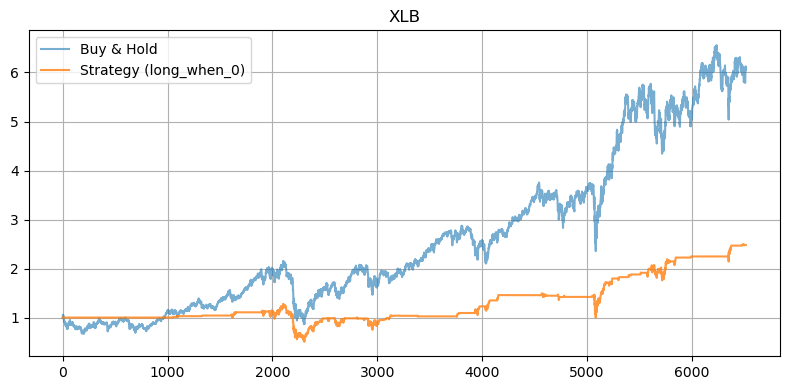

=== XLE ===
  mode: long_when_0
  Sharpe: 0.3410796060236147 (alt: 0.2173899099573156 )


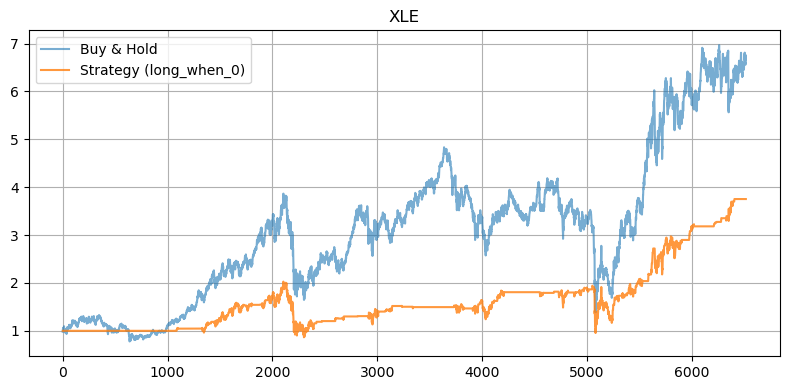

=== XLF ===


KeyError: 'centers'

In [4]:
import datetime
import importlib
import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
from lightgbm import LGBMClassifier

import misc
importlib.reload(misc)


def create_clf():
    """
    LightGBM の分類器を作るヘルパー。
    ラベルは 0/1 の二値なので objective='binary'。
    """
    clf = LGBMClassifier(
        objective="binary",
        n_estimators=200,
        learning_rate=0.05,
        num_leaves=31,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
    )
    return clf


def backtest_binary_signal(log_rets: pd.Series, w: pd.Series):
    """
    log_rets: ログリターン（Series, index=日付）
    w       : {0,1} のシグナル（同じ index）
              解釈: 日付 t における w[t] は「t+1 日に risky に乗るかどうか」を表す。

    戻り値:
      wealth: 初期1の資産曲線（Series）
      sharpe: 年率換算シャープレシオ
    """
    r = np.exp(log_rets) - 1.0

    w = w.astype(float)
    # w[t] を r[t+1] に掛ける → w を1日遅らせる
    w_lag = w.shift(1).fillna(0.0)
    w_lag = w_lag.reindex(log_rets.index).fillna(0.0)

    strat_ret = w_lag * r
    wealth = (1.0 + strat_ret).cumprod()

    if strat_ret.std(ddof=1) == 0:
        sharpe = 0.0
    else:
        sharpe = np.sqrt(252) * strat_ret.mean() / strat_ret.std(ddof=1)

    return wealth, sharpe


def choose_best_mapping(log_rets: pd.Series, w_raw: pd.Series):
    """
    w_raw: {0,1} の生シグナル。
    0/1戦略と1/0戦略の Sharpe を比較し、良い方を返す。
    戻り値:
      best_w: 採用するシグナル ({0,1})
      info  : dict（mode, sharpe, alt_sharpe, wealth）
    """
    w_raw = pd.Series(w_raw, index=log_rets.index)

    wealth_01, sharpe_01 = backtest_binary_signal(log_rets, w_raw)
    wealth_10, sharpe_10 = backtest_binary_signal(log_rets, 1 - w_raw)

    if sharpe_10 > sharpe_01:
        return (1 - w_raw), {
            "mode": "long_when_0",
            "sharpe": sharpe_10,
            "alt_sharpe": sharpe_01,
            "wealth": wealth_10,
        }
    else:
        return w_raw, {
            "mode": "long_when_1",
            "sharpe": sharpe_01,
            "alt_sharpe": sharpe_10,
            "wealth": wealth_01,
        }


def select_lambda(window: pd.Series, n_regimes, current_lambda, lambda_grid, train_ratio):
    """
    時系列CVで λ を選ぶ関数（0/1ストラテジーの Sharpe 最大化）。
    window: 単一資産のログリターン（Series）
    """
    n = len(window)
    if n < 100:
        return current_lambda
    
    X = misc.feature_engineer(window)
    scaler = misc.Scaler()
    clipper = misc.Clipper(mul=3)
    X_processed = scaler.fit_transform(clipper.fit_transform(X))
    
    split_idx = int(n * train_ratio)
    X_train = X_processed[:split_idx]
    X_valid = X_processed[split_idx-1:-1]
    rets_train = window.iloc[:split_idx]
    rets_valid = window.iloc[split_idx:]
    
    if len(rets_valid) < 10:
        return current_lambda 

    best_lambda = None
    best_sharpe = -np.inf
    for lambd in lambda_grid:
        model = misc.JumpModel(n_regimes=n_regimes, jump_penalty=lambd)
        model.fit(X_train)
        labels_train = misc.rearange_labels(model.labels, rets_train.values)
        
        y = labels_train[1:split_idx]        # s_{t+1}
        X_clf = X_processed[:split_idx-1]    # X_t
        if len(np.unique(y)) < 2:
            continue

        clf = create_clf()
        clf.fit(X_clf, y.astype(int))

        daily_returns = []
        # validation 部分: X_valid[i] で予測 → 翌日の rets_valid[i]
        for idx in range(len(X_valid)):
            x_i = X_valid[idx].reshape(1, -1)
            proba = clf.predict_proba(x_i)[0, 1]
            # 閾値固定でもよいが、CV 内ではシンプルに 0.5 で判定
            pred_regime_next = 1 if proba > 0.5 else 0
            r_next = float(rets_valid.iloc[idx])
            if pred_regime_next == 1:
                daily_returns.append(r_next)
            else:
                daily_returns.append(0.0)
        
        daily_returns = np.array(daily_returns)

        if daily_returns.std(ddof=1) == 0:
            sharpe = -np.inf
        else:
            sharpe = np.sqrt(252) * daily_returns.mean() / daily_returns.std(ddof=1)

        if sharpe > best_sharpe:
            best_sharpe = sharpe
            best_lambda = lambd
    
    if best_lambda is None:
        best_lambda = current_lambda

    return best_lambda


def run_with_online_lambda(
    rets, 
    start_idx, 
    n_regimes, 
    init_lambda,
    lambda_grid, 
    fit_freq_days,
    tscv_freq_days,
    tscv_window,
    tscv=True,
    extra_features=None,
    proba_threshold=0.55,   # シグナル用の閾値
):
    """
    JumpModel + LightGBM + オンライン λ 更新付きのレジーム予測。

    戻り値:
      out = {
        "w":        シグナル (0/1) Series,
        "lambda":   λ の時系列 Series,
        "mu_bull":  bull regime の平均リターンの時系列,
        "mu_bear":  bear regime の平均リターンの時系列,
        "proba":    LightGBM のクラス1確率の時系列,
      }
    """
    if lambda_grid is None:
        lambda_grid = [0.0, 0.1, 0.3, 1.0, 3.0, 10.0, 30.0, 100.0]

    scaler = misc.Scaler()
    clipper = misc.Clipper(mul=3)
    scaler2 = misc.Scaler()
    clipper2 = misc.Clipper(mul=3)
    
    model = misc.JumpModel(n_regimes=n_regimes, jump_penalty=init_lambda)
    clf = create_clf()
    
    last_fit_date = None
    last_tscv_date = None

    def should_fit(last_fit_date, current_date, freq_days):
        current = current_date.date()
        if last_fit_date is None:
            return True
        delta = current - last_fit_date
        return delta.days >= freq_days
    
    index = rets.index
    n = rets.shape[0]
    current_idx = start_idx
    end_idx = n - 1

    w = np.ones(n)
    lambdas = np.full(n, init_lambda)
    proba_path = np.full(n, np.nan)
    current_lambda = init_lambda
    mu_bull_path = np.full(n, np.nan)
    mu_bear_path = np.full(n, np.nan)

    # mu_bull, mu_bear の初期値（最初のループで上書きされる想定だが安全のため）
    mu_bull = 0.0
    mu_bear = 0.0

    while True:
        current_idx += 1
        obs = rets[:current_idx]
        current_date = obs.index[-1]

        # λ の TS-CV 更新
        if tscv and should_fit(last_tscv_date, current_date, tscv_freq_days) and len(obs) >= tscv_window:
            window = obs.iloc[-tscv_window:]
            selected_lambda = select_lambda(window, n_regimes, current_lambda, lambda_grid, train_ratio=0.7)
            current_lambda = selected_lambda
            model = misc.JumpModel(n_regimes=n_regimes, jump_penalty=current_lambda)
            last_tscv_date = current_date.date()
            last_fit_date = None
        
        X = misc.feature_engineer(obs)
        X2 = misc.feature_engineer_with_extra(obs, extra_df=extra_features)
        
        if should_fit(last_fit_date, current_date, fit_freq_days):
            last_fit_date = current_date.date()
            X_processed = scaler.fit_transform(clipper.fit_transform(X))
            X2_processed = scaler2.fit_transform(clipper2.fit_transform(X2))
            
            model.fit(X_processed)
            labels = misc.rearange_labels(model.labels, obs.values)

            if (labels == 1).any():
                mu_bull = obs.values[labels == 1].mean()
            else:
                mu_bull = 0.0
            if (labels == 0).any():
                mu_bear = obs.values[labels == 0].mean()
            else:
                mu_bear = 0.0

            y = pd.Series(labels, index=obs.index).shift(-1)
            y_idx = y.dropna().index
            clf = create_clf()
            clf.fit(
                pd.DataFrame(X2_processed, index=obs.index, columns=X2.columns).loc[y_idx], 
                y.loc[y_idx].astype(int)
            )
        else:
            X_processed = scaler.transform(clipper.transform(X))
            X2_processed = scaler2.transform(clipper2.transform(X2))
            
            pred_labels, pred_probs = model.prediction(X_processed)
            labels = misc.rearange_labels(pred_labels, obs.values)

        X2_df = pd.DataFrame(X2_processed, index=obs.index, columns=X2.columns)
        x_latest = X2_df.iloc[[-1]]
        proba = clf.predict_proba(x_latest)[0, 1]
        proba_path[current_idx] = proba

        # 閾値を超えたときだけロング、それ以外キャッシュ
        w[current_idx] = 1.0 if proba > proba_threshold else 0.0
        lambdas[current_idx] = current_lambda
        mu_bull_path[current_idx] = mu_bull
        mu_bear_path[current_idx] = mu_bear

        if current_idx == end_idx:
            break
    
    out = {
        "w": pd.Series(w, index=index),
        "lambda": pd.Series(lambdas, index=index),
        "mu_bull": pd.Series(mu_bull_path, index=index),
        "mu_bear": pd.Series(mu_bear_path, index=index),
        "proba": pd.Series(proba_path, index=index),
    }
    return out


def plot_price_and_signal(log_rets: pd.Series, w: pd.Series, title=""):
    """
    簡易プロット: Buy&Hold とバイナリ戦略の価格曲線。
    """
    r = np.exp(log_rets) - 1.0
    wealth_bh = (1.0 + r).cumprod()

    wealth_strat, _ = backtest_binary_signal(log_rets, w)

    plt.figure(figsize=(8, 4))
    plt.plot(wealth_bh.index, wealth_bh.values, label="Buy & Hold", alpha=0.6)
    plt.plot(wealth_strat.index, wealth_strat.values, label="Binary Strategy", alpha=0.8)
    plt.grid(True)
    plt.legend()
    plt.title(title)
    plt.tight_layout()
    plt.show()


# ======================
# 実行部
# ======================

start_date = "2000-01-01"
end_date = datetime.datetime.now().strftime("%Y-%m-%d")

ticker = [
    "XLB", "XLE", "XLF", "XLI", "XLK", "XLP", "XLU", "XLV", "XLY"
]
df = yf.download(ticker, start=start_date, end=end_date)["Close"]
rets = np.log(df).diff().dropna()

assets = rets.columns

start_idx = 1000
n_regimes = 2
init_lambda = 100.0
lambda_grid = [0.0, 5.0, 10.0, 50.0, 100.0]
fit_freq_days = 7 * 4
tscv_freq_days = 21 * 3
tscv_window = 252 * 5

results = {}

for asset in assets:
    print(f"=== {asset} ===")
    out = run_with_online_lambda(
        rets[asset],
        start_idx=start_idx,
        n_regimes=n_regimes,
        init_lambda=init_lambda,
        lambda_grid=lambda_grid,
        fit_freq_days=fit_freq_days,
        tscv_freq_days=tscv_freq_days,
        tscv_window=tscv_window,
        tscv=True,
        extra_features=None,      # ここにマクロDFを渡せば features に追加可能
        proba_threshold=0.55,
    )

    w_raw = out["w"]
    w_best, info = choose_best_mapping(rets[asset], w_raw)

    print("  mode:", info["mode"])
    print("  Sharpe:", info["sharpe"], "(alt:", info["alt_sharpe"], ")")

    # プロット（Buy&Hold vs ベスト戦略）
    wealth = info["wealth"]
    r = np.exp(rets[asset]) - 1.0
    wealth_bh = (1.0 + r).cumprod()

    plt.figure(figsize=(8, 4))
    plt.plot(wealth_bh.values, label="Buy & Hold", alpha=0.6)
    plt.plot(wealth.values, label=f"Strategy ({info['mode']})", alpha=0.8)
    plt.grid(True)
    plt.legend()
    plt.title(asset)
    plt.tight_layout()
    plt.show()

    results[asset] = {
        "out": out,
        "w_raw": w_raw,
        "w_best": w_best,
        "info": info,
    }


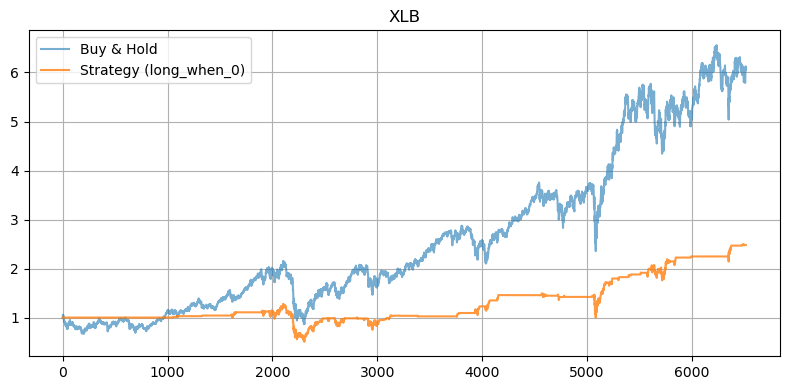

In [3]:
plt.figure(figsize=(8, 4))
plt.plot(wealth_bh.values, label="Buy & Hold", alpha=0.6)
plt.plot(wealth.values, label=f"Strategy ({info['mode']})", alpha=0.8)
plt.grid(True)
plt.legend()
plt.title(asset)
plt.tight_layout()
plt.show()
